In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors as colors
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import geopandas
import geopandas as gpd
from geopandas.tools import sjoin

from shapely.geometry import Point

from scipy.interpolate import interp1d

import datetime

from tqdm import tqdm
import networkx as nx

import sys
sys.path.insert(1, '../graph_construction/')
from WI_graph_functions import *

In [2]:
# Read in the needed data

WILakes  = pd.read_pickle("../graph_construction/WILakes.df")
WIRivers = pd.read_pickle("../graph_construction/WIRivers.df")
agland   = pd.read_pickle("../graph_construction/agland.df")
agland = agland[agland.isAG == 1].copy(deep = True).reset_index(drop = True)

HUC8  = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC8/HUC8.shp")
HUC10 = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC10/HUC10.shp")
HUC12 = gpd.GeoDataFrame.from_file("../graph_construction/WIgeodataframes/HUC12/HUC12.shp")

WItofroms       = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms.csv")
WItofroms_lakes = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms_lakes.csv")
WItofroms_agg   = pd.read_csv("../graph_construction/WIgeodataframes/WItofroms_agg.csv")

WI    = gpd.GeoDataFrame.from_file("../graph_construction/lakes_rivers/WI/WI.shp")
CAFOS = gpd.GeoDataFrame.from_file("../graph_construction/CAFOS_shp/CAFOS_shp.shp")

In [3]:
# Build the aggregated graph
G_agg = build_graph(WItofroms_agg)

In [4]:
# Build the original graph
G_lakes = build_graph(WItofroms_lakes)

In [5]:
# Add CAFOs to the original graph
G_CAFOS = add_CAFOS_to_graph(G_lakes, WILakes, WIRivers, CAFOS)

G_CAFOS_pos, node_colors_CAFOS, node_size_CAFOS = get_pos_dict_with_pollutant(G_CAFOS, WILakes, WIRivers, CAFOS)

100%|████████████████████████████████████████████████████████████████████████████| 46245/46245 [09:40<00:00, 79.62it/s]


In [6]:
# Build the upstream graph for Altoona Lake and Lake Mohawksin
Alt,  Alt_colors  = get_upstream_graph(G_CAFOS, 13097728,  WILakes, WIRivers)
Moh,  Moh_colors  = get_upstream_graph(G_CAFOS, 120052157, WILakes, WIRivers)

In [23]:
# Define a function to plot the upstream graph;

def plot_with_watersheds(G, G_pos, G_cols, lake_gdf, river_gdf, HUC12, HUC10, WI_too = False,comid_too = False, comid=0, node_size = 20, arrowsize=5, leg = False):
    """
    Plots the upstream graph overlayed on the huc12s and with waterbody polygons shown. Waterbody of interest can be 
    labeled with a gold star
    """
    
    # Get the list of all nodes
    all_nodes = [i for i in G.nodes]
    
    # Get all the rivers and waterbodies in the upstream graph
    rivers = river_gdf[river_gdf.COMID.isin(all_nodes)]
    lakes  = lake_gdf[lake_gdf.COMID.isin(all_nodes)]
    
    # Get a list of the huc12s for all the nodes in the upstream graph
    huc12_rivs  = [i for i in rivers.huc12.values]
    huc12_lakes = [i for i in lakes.huc12.values]
    huc12_vals = huc12_lakes + huc12_rivs
    huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
    
    # Get a list of the huc10s for all the nodes in the upstream graph 
    huc10_vals = [i for i in lakes.huc10.values]
    huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]
    
    # Define a plot, and plot the huc12s and lakes
    fig, ax = plt.subplots(figsize=(13,13))
    huc12s.plot(ax=ax, color="none", edgecolor="black")
    lakes.plot(ax=ax, color="skyblue", zorder = 0)
    
    # Optional arguments can also be passed to the function; these allow for plotting the entire state of Wisconsin,
    # adding a gold star for the most downstream node, and adding a legend
    if WI_too:
        WI.plot(ax=ax, color="none", edgecolor="black")
    if comid_too:
        WILakes[WILakes.COMID == comid].centroid.plot(ax=ax, markersize=400,marker="*", color="gold",edgecolors="black",linewidth = 1,zorder=151)
    if len(CAFOS[CAFOS.huc12.isin(huc12_vals)])>0:
        CAFOS[CAFOS.huc12.isin(huc12_vals)].centroid.plot(ax=ax, markersize=120, color="orange",marker="s", zorder=150)
    
    legend_elements = [
                   Line2D([0],[0], markersize=10, label="Waterbody Node",marker='o', color='blue',linestyle="None"),
                   Line2D([0],[0], markersize=10, label="River Node",marker='o',color='red',linestyle="None"),
                   Line2D([0],[0], markersize=10, label="CAFO", marker="s", color="purple", linestyle="None"),
                   Line2D([0],[0], markersize=18, label="Lake", marker="*", color="gold", linestyle="None", markeredgecolor="black"),
                   Patch(facecolor="green", edgecolor="none", label="Agricultural Land")]
    nx.draw_networkx(G,pos=G_pos,node_size=node_size,with_labels=False,ax=ax,arrowsize=arrowsize,node_color=G_cols)
    
    if leg:
        ax.legend(handles=legend_elements, loc = 'upper left',fontsize=22)
    plt.show()

    
def plot_with_watersheds_agland(G, G_pos, G_cols, lake_gdf, river_gdf, HUC12, HUC10,agland, WI_too = False,comid_too = False, comid=0, node_size = 20, arrowsize=5,leg=False):
    """
    Plots the upstream graph overlayed on the huc12s and with waterbody polygons and agricultural land
    polygons shown. Waterbody of interest can be labeled with a gold star
    """
        
    # Get the list of all nodes 
    all_nodes = [i for i in G.nodes]
    
    # Get all the rivers and waterbodies in the upstream graph 
    rivers = river_gdf[river_gdf.COMID.isin(all_nodes)]
    lakes  = lake_gdf[lake_gdf.COMID.isin(all_nodes)]
    
    # Get a list of all the huc12s in the upstream graph 
    huc12_rivs  = [i for i in rivers.huc12.values]
    huc12_lakes = [i for i in lakes.huc12.values]
    huc12_vals = huc12_lakes + huc12_rivs
    huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
    
    # Get a list of all the huc10s in the upstream graph 
    huc10_vals = [i for i in lakes.huc10.values]
    huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]
    
    # Get the agricultural land that is in the watershed of the upstream graph 
    aglands = agland[agland.huc12.isin(huc12_vals)]
    
    # Plot the data
    fig, ax = plt.subplots(figsize=(13,13))
    aglands.plot(ax=ax, color="forestgreen")
    huc12s.plot(ax=ax, color="none", edgecolor="black")
    lakes.plot(ax=ax, color="skyblue",zorder = 0)
    if WI_too:
        WI.plot(ax=ax, color="none", edgecolor="black")
    if comid_too:
        WILakes[WILakes.COMID == comid].centroid.plot(ax=ax, markersize=400,marker="*", color="gold",edgecolors="black",linewidth = 1,zorder=151)
    if len(CAFOS[CAFOS.huc12.isin(huc12_vals)])>0:
        CAFOS[CAFOS.huc12.isin(huc12_vals)].centroid.plot(ax=ax, markersize=120, color="orange",marker="s", zorder=150)
    legend_elements = [Line2D([0],[0], color="black", lw=2, label="HUC12 Watershed"),
                   Line2D([0],[0], markersize=10, label="Waterbody Node",marker='o', color='blue',linestyle="None"),
                   Line2D([0],[0], markersize=10, label="River Node",marker='o',color='red',linestyle="None"),
                   Line2D([0],[0], markersize=15, label="CAFO", marker="s", color="orange", linestyle="None"),
                   Line2D([0],[0], markersize=18, label="Altoona Lake", marker="*", color="gold", linestyle="None", markeredgecolor="black"),
                   Patch(facecolor="skyblue", edgecolor="none", label="Waterbody"),
                   Patch(facecolor="green", edgecolor="none", label="Agricultural Land")]
    nx.draw_networkx(G,pos=G_pos,node_size=node_size,with_labels=False,ax=ax,arrowsize=arrowsize,node_color=G_cols)
    
    if leg:
        ax.legend(handles=legend_elements, loc = 'upper left',fontsize=22)
    plt.show()




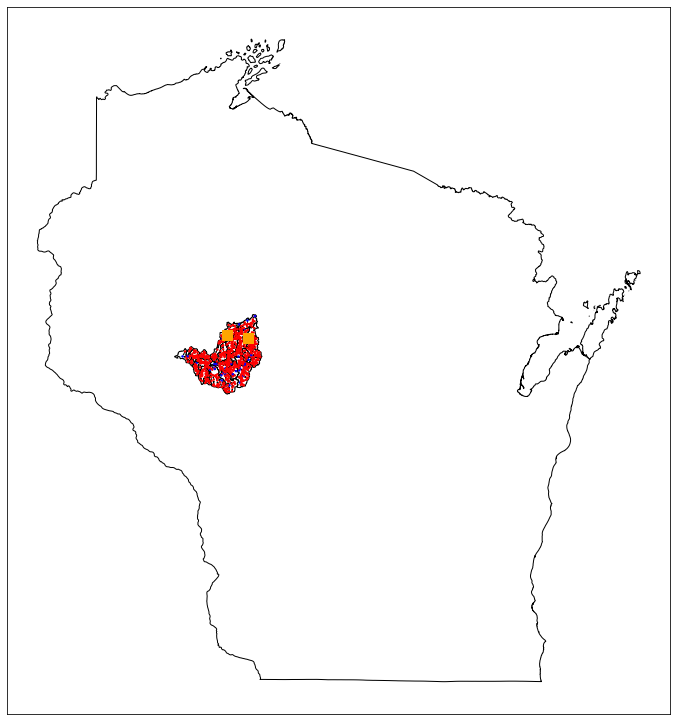

In [8]:
# Plot Altoona Lake with Wisconsin shown
plot_with_watersheds(Alt, G_CAFOS_pos, Alt_colors, WILakes, WIRivers, HUC12, HUC10, True, False, 13097728,2,1)

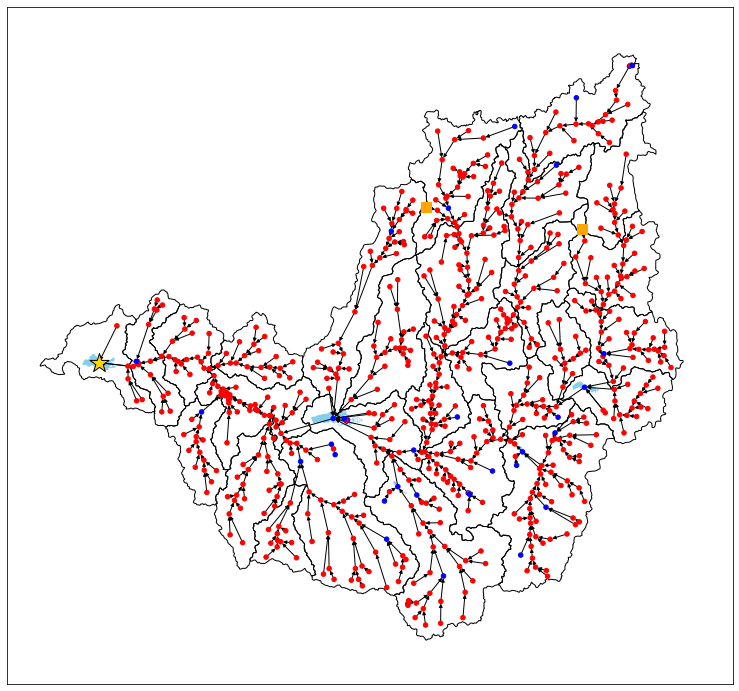

In [9]:
# Plot Altoona Lake without agricultural land 
plot_with_watersheds(Alt, G_CAFOS_pos, Alt_colors, WILakes, WIRivers, HUC12, HUC10, False, True, 13097728,20,7)

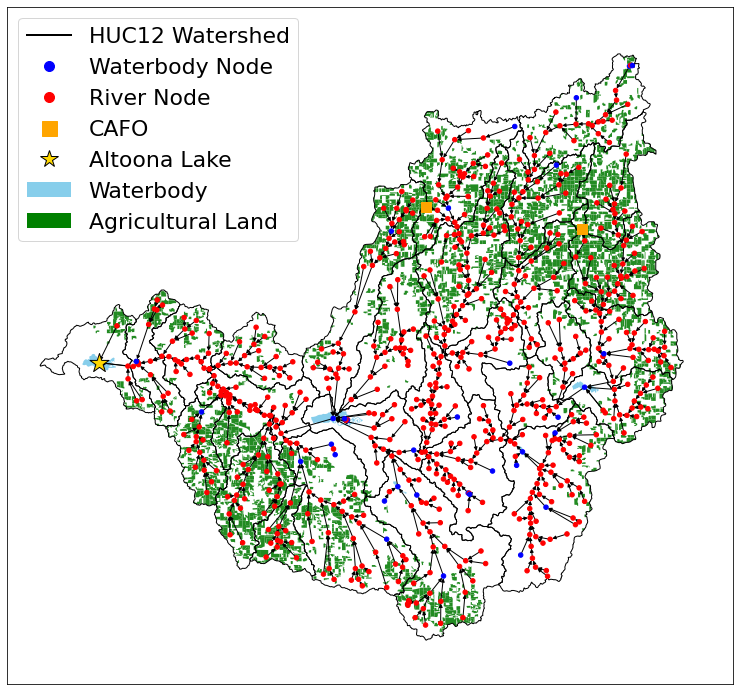

In [22]:
# Plot Altoona Lake with agricultural land
plot_with_watersheds_agland(Alt, G_CAFOS_pos, Alt_colors, WILakes, WIRivers, HUC12, HUC10,agland,  False, True, 13097728,20,7, True)

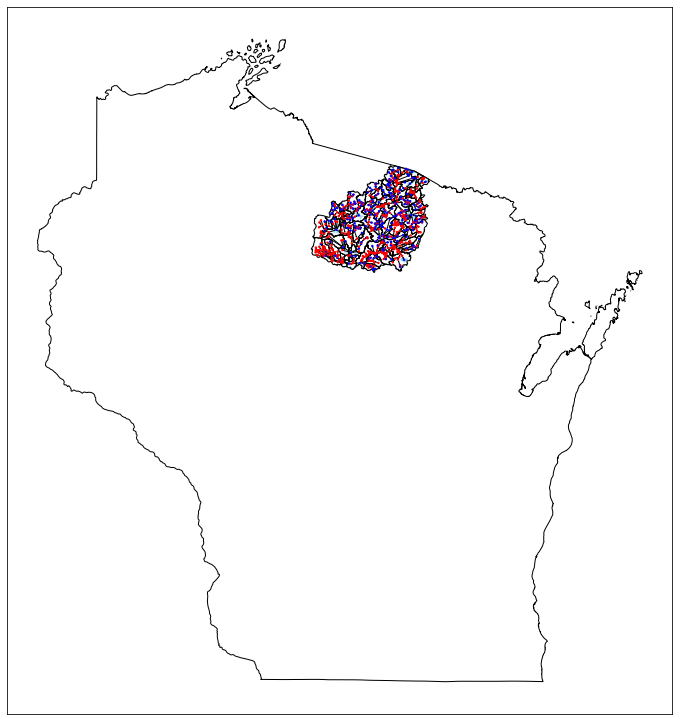

In [11]:
# Plot Lake Mohawksin with Wisconsin shown
plot_with_watersheds(Moh, G_CAFOS_pos, Moh_colors, WILakes, WIRivers, HUC12, HUC10, True, False, 120052157,2,1)

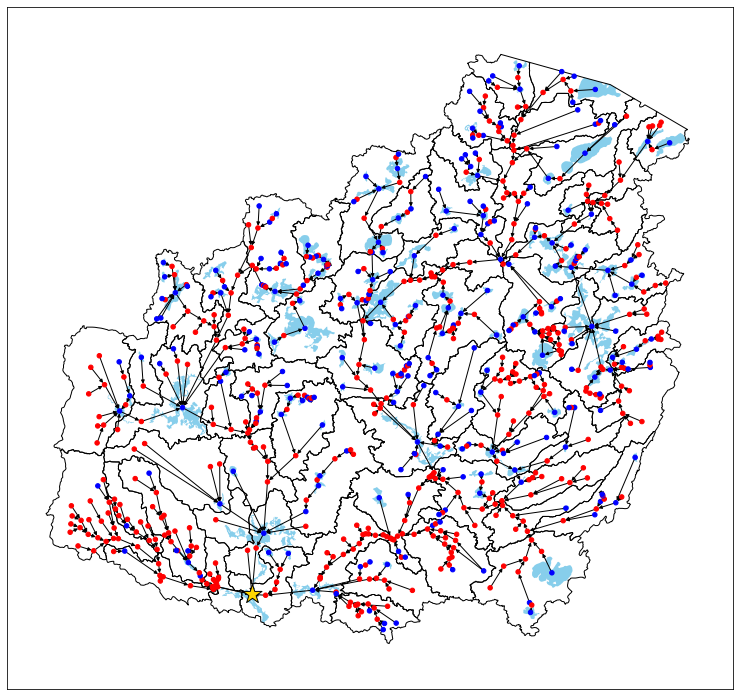

In [12]:
# Plot Lake Mohawksin without agricultural land
plot_with_watersheds(Moh, G_CAFOS_pos, Moh_colors, WILakes, WIRivers, HUC12, HUC10, False, True, 120052157,20,7)

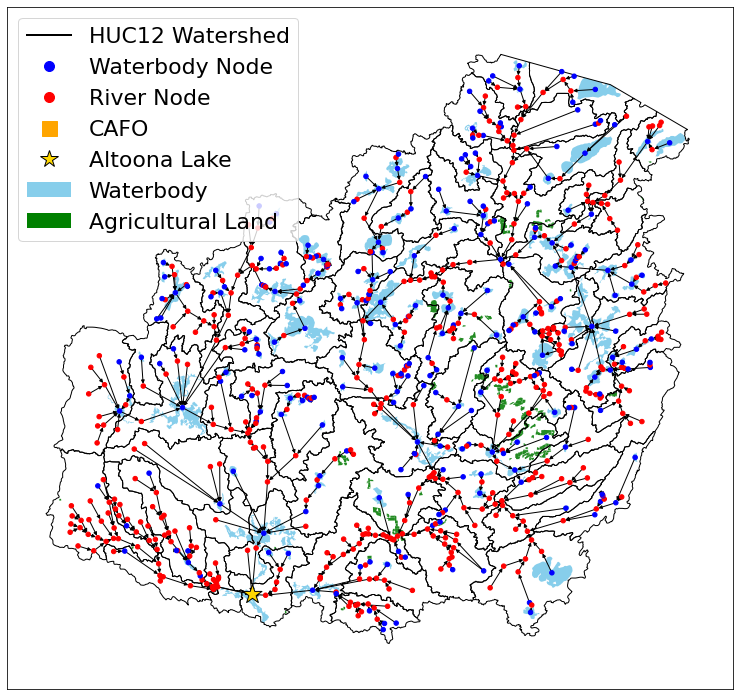

In [24]:
# Plot Lake Mohawksin with agricultural land 
plot_with_watersheds_agland(Moh, G_CAFOS_pos, Moh_colors, WILakes, WIRivers, HUC12, HUC10,agland, False, True, 120052157,20,7, True)

In [14]:
def get_ag_fraction(G, lake_gdf, river_gdf,agland):
    """
    Returns the agricultural land fraction in the watershed of a given graph, G 
    """
    
    # Get the set of all nodes in the graph 
    all_nodes = [i for i in G.nodes]
    
    # Get the GeoDataFrame of all waterbodies and rivers in the graph 
    rivers = river_gdf[river_gdf.COMID.isin(all_nodes)].copy(deep=True)
    lakes  = lake_gdf[lake_gdf.COMID.isin(all_nodes)].copy(deep=True)
    
    # Get the list of huc12s in the graph 
    huc12_rivs  = [i for i in rivers.huc12.values]
    huc12_lakes = [i for i in lakes.huc12.values]
    huc12_vals = huc12_lakes + huc12_rivs
    huc12s     = HUC12[HUC12.huc12.isin(huc12_vals)]
    
    # Get the list of huc10s in the graph 
    huc10_vals = [i for i in lakes.huc10.values]    
    huc10s     = HUC10[HUC10.huc10.isin(huc10_vals)]
    
    # Get the agricultural land in the upstream watershed
    aglands = agland[agland.huc12.isin(huc12_vals)]
    
    # Get the area of the huc12
    HUC12_area = np.sum(huc12s.area.values)
    
    # Get the area of the overlayed agricultural land
    ag_area    = np.sum(aglands.area.values)
    
    print("The agricultural land fraction of the given lake is ")
    print(ag_area/HUC12_area)
    
# Get the area of all upstream lakes
def get_lake_sqkm(G, lake_gdf):
    all_nodes = [i for i in G.nodes]
    
    lakes = lake_gdf[lake_gdf.COMID.isin(all_nodes)].copy(deep=True)
    
    areas = np.sum(lakes.AREASQKM.values)
    
    print("The area of the lakes in the graph is ")
    print(areas)
    print("The number of lakes in the graph is ")
    print(len(lakes))

In [15]:
get_ag_fraction(Alt, WILakes, WIRivers, agland)

The agricultural land fraction of the given lake is 
0.2060324423241711


In [16]:
get_ag_fraction(Alt, WILakes, WIRivers, agland)

The agricultural land fraction of the given lake is 
0.2060324423241711


In [17]:
get_ag_fraction(Moh, WILakes, WIRivers, agland)

The agricultural land fraction of the given lake is 
0.006775575860429062


In [18]:
get_lake_sqkm(Alt, WILakes)

The area of the lakes in the graph is 
10.359
The number of lakes in the graph is 
35


In [19]:
get_lake_sqkm(Moh, WILakes)

The area of the lakes in the graph is 
353.50300000000004
The number of lakes in the graph is 
266


In [20]:
Alt_area = WILakes.AREASQKM[WILakes.COMID == 13097728].iloc[0]
Moh_area = WILakes.AREASQKM[WILakes.COMID == 120052157].iloc[0]

print("Altoona Lake upstream area is ", 10.359-Alt_area)
print("Lake Mohawksin upstream area is ", 353.503-Moh_area)

Altoona Lake upstream area is  7.426
Lake Mohawksin upstream area is  345.505
